# MSS18 MergeBCs
- Detect outlier BCs
- Remove  outlier BCs
- Combine reads for all BCs
- Calcualte activity


### Reprocess p53 data with similar approach
- Detect outlier BCs
- Remove them
- Combine reads for all BCs
- Calcualte activity
- Combine replicates with Zscores


### Add empty TF plasmid to Designed BC list
- added June 2021: detect 'No AD' TF barcode and use this to adjust replicates


In [1]:
from Bio.Seq import Seq
from Bio.Alphabet import generic_dna 
import pandas as pd
import numpy as np
import itertools
import string
import random
from sklearn.linear_model import LinearRegression
import re
import matplotlib.pyplot as plt
from collections import defaultdict 
import scipy
from scipy import stats
import glob
import PreprocessingFunctions_LC2AcidBlobs as PF
import warnings
warnings.filterwarnings('ignore')
import matplotlib
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42
import os
import glob
from statsmodels.formula.api import ols
from statsmodels.stats.anova import anova_lm
from statsmodels.graphics.factorplots import interaction_plot

Folder = '20210722/'

if (os.path.isdir('Figures/')):
    print 'Figures folder exists'
else:
    os.mkdir('Figures')
if (os.path.isdir('Figures/'+Folder)):
    print 'Today I will save files in Figures/%s' %Folder
else:
    os.mkdir('Figures/'+Folder)

# DesignedBCs = list(LegacyDF.Barcode)

Figures folder exists
Today I will save files in Figures/20210722/


# Filter on Read Depth, Remove Outliers and merge all BCs
new processing function returns second DF with 3 activity calculations

In [2]:
LegacyDF_original = pd.read_pickle('../AnalysisSuportFiles/Pickle_LC2_BCDF') # changed 20200210
LegacyDF_original.loc[len(LegacyDF_original.index)] = ['', 'ATCGATCGA', 'GCTAGCATCGATCGACTCGAG'] 

# DesignedBCs_AcidicADs = list(LegacyDF_original.Barcode)

def processReadCounts_v2(ExpName,data_dir,BinValues,readthreshold,removeOutliers=False,DesignDF=LegacyDF_original):
    filelist = sorted( glob.glob(data_dir+'*.txt'))
    DesignedBCs = list(DesignDF.Barcode)
    nBCs,columnNames = len(DesignedBCs),[]
    barcodecounts = np.zeros(shape=(nBCs,len(filelist)))
    ExportDF = DesignDF[['ADseq','Barcode']] #changed 20200207 to add the ADseq col
    debuggingcounter =0
    k =0
    print 'Design file contains %i barcodes and %i ADs' %(len(set(DesignedBCs)),len(set(list(DesignDF.ADseq))))
    for index, filename in enumerate(filelist):
        myfile = open(filename,'r')
        currentFile = myfile.readlines()
        BCcountsDict = defaultdict(int)
        BCmatchCounter, BCmatchReadCounter, TotalReadCounter = 0,0,0

        print '%s has %i unique sequences' %(filename, len(currentFile))
        for line in currentFile:
            count, seq = line.split()
            count = int(count)
            TotalReadCounter += count
            if (len(seq) == 23)or(len(seq) ==20): #only use reads that have right length after the GREP
                BC = seq[5:-6] # BC LENGTH IS 12 FOR LIBRARY AND 9 FOR EMPTY PLASMID
                if BC in DesignedBCs:
                    BCmatchCounter += 1
                    BCmatchReadCounter += count
#                     if count >readthreshold: # 20190304 notice that thershold is taken early. not sure why
                    if count >0:
                        BCcountsDict[BC] += count # only add the BC to the dictionary if it is above the threshold
        fractionReadsMatching = 100.0* BCmatchReadCounter/TotalReadCounter
        print '%i reads with %i matching designed BCs' %(TotalReadCounter,BCmatchReadCounter)
        print '%i BC matches containing %.1f percent of reads' % (BCmatchCounter, fractionReadsMatching)
        # take the count Dictionary and make it into a count matrix with zeros for all the missing data.
        for i, barcode in enumerate(DesignedBCs):
            barcodecounts[i,index] = BCcountsDict[barcode]
        ##########################################
        # add raw counts to the masterDataFrame
        columnName = filename.split('/')[-1].split('.')[0] # first find the filename, then take first part
        columnNames.append(columnName)
        tempBClistDF = ExportDF.Barcode # temp DF for mapping BCs to counts
        tempMap = tempBClistDF.map(BCcountsDict) #much slower (but fast enough)
        ExportDF.loc[:,columnName] = tempMap
    ##########################################################################################    
    # total number of barcoes found accross all samples:
    Number_Designed_BCs_Found = sum(np.sum(barcodecounts,axis=1)>0)
    print '\nIn total, %i designed barcodes were found in this experiment' % Number_Designed_BCs_Found
    # remove barcodes with very few reads
    ThresholdedBCcounts = np.zeros_like(barcodecounts)
    nBCsOverThresh = 0
    for i in xrange(0,nBCs):
        temp = barcodecounts[i,:]
        if sum(temp) > readthreshold: #only counts does no manipulations
            nBCsOverThresh +=1
            ThresholdedBCcounts[i,:] = temp # copies rows that have enough reads
    TotalCountsPerBC = np.sum(ThresholdedBCcounts,axis=1)
    print "There are %r Barcodes with more than %r reads" % (nBCsOverThresh, readthreshold)
    print "There are %r Barcodes with <= %r reads\n" % (Number_Designed_BCs_Found-nBCsOverThresh, readthreshold)
    ##########################################################################################
    # normalize each column by the total number of BC matches in the column i.e. control for sequencing efficiency.
    NormBCcounts1 = np.zeros(shape=(barcodecounts.shape))
    for i in xrange(0,barcodecounts.shape[1]):
        temp = ThresholdedBCcounts[:,i]
        NormBCcounts1[:,i] = temp/sum(temp)
    # normalize each row by total BC matches in the row i.e. calculate relative abundance
    NormBCcounts2 = np.zeros(shape=barcodecounts.shape)
    for i in xrange(0,barcodecounts.shape[0]):
        temp = NormBCcounts1[i,:]
        if sum(temp) > 0:
            NormBCcounts2[i,:]=temp/(sum(temp))
    ##########################################################################################
    ## enter Normalized BCcounts into LegacyDF
    Norm1ColumnNames = [] # make a list of the Norm1 columns names for recomputing 
    for i in xrange(0,NormBCcounts2.shape[1]):
        columnName = columnNames[i]+'_norm1' 
        Norm1ColumnNames.append(columnName)
        ExportDF[columnName]=NormBCcounts1[:,i] #  first intermediate normalization for debugging
#         columnName = columnNames[i]+'_norm2'
#         ExportDF[columnName]=NormBCcounts2[:,i] # save intermediate for debugging
    ##########################################################################################
    # convert relative abundance across bins into  Expected Fluorescence Value
    Activity = NormBCcounts2.dot(BinValues.transpose())
    ActivityVariance = np.var(NormBCcounts2*BinValues,axis=1)# 20200207 I am starting to doubt this calculation
    ActivitySTD      = np.std(NormBCcounts2*BinValues,axis=1)
    # plot histogram of expression values:
    plothist =0
    if plothist ==1:
        num_bins = 40
        n, bins, patches = plt.hist(Activity[Activity>0], num_bins, normed=0, facecolor='green', alpha=0.5)
        plt.xlabel('Activity')
        plt.ylabel('Counts')
        plt.show()   
    ##########################################################################################
    # enter Activity and ActivityVariance into ExportDF
    ExportDF.loc[:,ExpName+'_Activity'] = Activity
    ExportDF.loc[:,ExpName+'_std'] = ActivitySTD
    ExportDF.loc[:,ExpName+'_SEM'] = ActivitySTD/np.sqrt(TotalCountsPerBC)
    ExportDF.loc[:,ExpName+'_totalReads'] = TotalCountsPerBC
    ##########################################################################################
    # detect outlier BCs
    AvgADActivityAllBCs_Dict = defaultdict(float)
    AvgADActivityOutliersRemoved_Dict = defaultdict(float)
    AvgADActivityOutliersRemovedAndBCsCollapsed_Dict = defaultdict(float)
    BCsperAD_Dict = defaultdict(float)
    BCsperAD_DictOutliersRemoved = defaultdict(float)
    NonOutlierBCs_Dict ={}
    
    print Norm1ColumnNames
    if removeOutliers ==True:
        
        nSigmas = 2
        #For each AD, find all BCs
        for ad in list(set(ExportDF.ADseq)):  
            indx = (ExportDF.ADseq == ad)&(ExportDF[ExpName+'_totalReads']>readthreshold)
            tempDF = ExportDF[indx]
            BCsperAD_Dict[ad] =sum(indx)
            tempActivities = tempDF[ExpName+'_Activity']
            #calculate mean and sigma
            tempMU = np.mean(tempActivities)
            AvgADActivityAllBCs_Dict[ad] = tempMU # store the activity over all BCs for comparisons later
            tempSTD = np.std(tempActivities)
            # find outliers
            mask = np.absolute(tempActivities-tempMU)<(nSigmas*tempSTD)
            BCsperAD_DictOutliersRemoved[ad] = sum(mask)
            # keep track of which BCs are outliers
            tempBCdict = dict(zip(tempDF.Barcode,mask))
            NonOutlierBCs_Dict.update(tempBCdict) # note True means BC is not an outlier; False means BC is an outlier
            # recalculate activity without outlier BCs
            tempActivities_NoOutliers = np.array(tempActivities[mask].values)
            AvgADActivityOutliersRemoved_Dict[ad] = np.mean(tempActivities_NoOutliers)
            
            ## go back to NormBCcounts1 columns and remove the outlier BCs
            tempDF2 = tempDF[mask]
            tempDF3 = tempDF2[Norm1ColumnNames]
            #sum together all the counts of the different barcodes together
            Norm1BCCountsSum = tempDF3.sum(axis=0)
            
            # recalculate NormBCcounts3 (new version of NormBCCounts2)
            NormBCcounts3=Norm1BCCountsSum/(sum(Norm1BCCountsSum))
            AvgADActivityOutliersRemovedAndBCsCollapsed_Dict[ad] = NormBCcounts3.dot(BinValues.transpose())
            
            ##catch the empty TF.  Allows only '1 Barcode' to pass the outlier detection 
            if ad =='':
                print 'Found the No AD control'
                AvgADActivityOutliersRemoved_Dict[ad] = AvgADActivityAllBCs_Dict[ad]
                AvgADActivityOutliersRemovedAndBCsCollapsed_Dict[ad] =AvgADActivityAllBCs_Dict[ad]
                BCsperAD_DictOutliersRemoved[ad] = BCsperAD_Dict[ad]
                debuggingcounter +=1

            
            debugging=0
            if debugging:
                if k < 4:
#                     print Norm1BCCountsSum
#                     print NormBCcounts3
#                     print NormBCcounts3.dot(BinValues.transpose())
                    k +=1 
                    print '%i of %i barcodes are included' % (sum(mask),sum(indx))
                    print 'tempMU %f'%tempMU
                    print 'mean without outliers %f'% np.mean(tempActivities_NoOutliers)
                    print AvgADActivityOutliersRemoved_Dict[ad]
                    print AvgADActivityOutliersRemovedAndBCsCollapsed_Dict[ad]
                    
    ## add a column to ExportDF that encodes if the BC is an outlier
    ## fixed these lines 20200519 because they were not getting exported properly
    verytempdata = tempBClistDF.map(NonOutlierBCs_Dict)
    ExportDF.loc[:,'NonOutlierBarcodes']= verytempdata
    

    
    ## combine AD avg data into a second Export DF for ADs only:
    ExportDF_ADs = pd.DataFrame({'ADseq':list(set(ExportDF.ADseq))})
    tempADlist =  ExportDF_ADs.ADseq
    ExportDF_ADs[ExpName+'AvgADActivityAllBCs']= tempADlist.map(AvgADActivityAllBCs_Dict)
    ExportDF_ADs[ExpName+'AvgADActivityOutliersRemoved']= tempADlist.map(AvgADActivityOutliersRemoved_Dict)
    ExportDF_ADs[ExpName+'AvgADActivityOutliersRemovedAndBCsCollapsed']= tempADlist.map(AvgADActivityOutliersRemovedAndBCsCollapsed_Dict)
    ExportDF_ADs[ExpName+'BCsperAD']= tempADlist.map(BCsperAD_Dict)
    ExportDF_ADs[ExpName+'BCsperADOutliersRemoved']= tempADlist.map(BCsperAD_DictOutliersRemoved)
    ##########################################################################################
    # return LegacyDF to jupyter notebook running this script
    print ExportDF.columns
    print 'Found %i empty ADs'  % debuggingcounter
    cols_to_use = ExportDF.columns[2:] #changed 20200207 because I added the ADseq col
    return ExportDF[cols_to_use], ExportDF_ADs
    
    
    

# NextSeq Run 202014


In [3]:
readthreshold = 10 # do not include barcodes with fewer than this many reads
ExpName = 'MSS18_Sort_1' # 
# BinValues = np.array([1,2,3,4]) #
BinValues = np.array([82.3,604,2037,11215]) #
data_dir = '../../Data/MSS18/Sort1_2_3_NextSeq/Sort1/' 
testDF1,testAD_DF1 = processReadCounts_v2(ExpName,data_dir,BinValues,readthreshold,removeOutliers=True)
# testDF1.to_pickle('pickleFiles/MSS18nextseq/%s_%i'%(ExpName,readthreshold))


ExpName = 'MSS18_Sort_2' # 
BinValues = np.array([56.5,489,1755,9456]) #
data_dir = '../../Data/MSS18/Sort1_2_3_NextSeq/Sort2/' 
testDF2,testAD_DF2 = processReadCounts_v2(ExpName,data_dir,BinValues,readthreshold,removeOutliers=True)
# testDF2.to_pickle('pickleFiles/MSS18nextseq/%s_%i'%(ExpName,readthreshold))
tempDF2 = pd.merge(testDF1, testDF2, left_index=True, right_index=True, how='outer')

ExpName = 'MSS18_Sort_3' # 
BinValues = np.array([43.7,471,1750,9431]) #
data_dir = '../../Data/MSS18/Sort1_2_3_NextSeq/Sort3/' 
testDF3,testAD_DF3 = processReadCounts_v2(ExpName,data_dir,BinValues,readthreshold,removeOutliers=True)
# testDF3.to_pickle('pickleFiles/MSS18nextseq/%s_%i'%(ExpName,readthreshold))
tempDF3 = pd.merge(tempDF2, testDF3, left_index=True, right_index=True, how='outer')

ExpName = 'MSS18_Sort_4' #D 
BinValues = np.array([41.2,386,1618,9716]) #
data_dir = '../../Data/MSS18/Sort4_5A_5B/NextSeqRepeatLigatedAdaptors/Sort4/' # 
testDF4,testAD_DF4 = processReadCounts_v2(ExpName,data_dir,BinValues,readthreshold,removeOutliers=True)
# testDF4.to_pickle('pickleFiles/MSS18nextseq/%s_%i'%(ExpName,readthreshold))
tempDF4 = pd.merge(tempDF3, testDF4, left_index=True, right_index=True, how='outer')

ExpName = 'MSS18_Sort_5' #D 
BinValues = np.array([23.4,49.4,84.1,176,464,1292,5184,18964]) #
data_dir = '../../Data/MSS18/Sort4_5A_5B/NextSeqRepeatLigatedAdaptors/Sort5/' # 
testDF5,testAD_DF5 = processReadCounts_v2(ExpName,data_dir,BinValues,readthreshold,removeOutliers=True)
# testDF5.to_pickle('pickleFiles/MSS18nextseq/%s_%i'%(ExpName,readthreshold))
tempDF5 = pd.merge(tempDF4, testDF5, left_index=True, right_index=True, how='outer')




../../Data/MSS18/Sort1_2_3_NextSeq/Sort1/MSS18_01.txtsorted.txt has 36737 unique sequences
3419512 reads with 3269458 matching designed BCs
8016 BC matches containing 95.6 percent of reads
../../Data/MSS18/Sort1_2_3_NextSeq/Sort1/MSS18_02.txtsorted.txt has 36931 unique sequences
4273327 reads with 4110756 matching designed BCs
8028 BC matches containing 96.2 percent of reads
../../Data/MSS18/Sort1_2_3_NextSeq/Sort1/MSS18_03.txtsorted.txt has 36107 unique sequences
4508554 reads with 4351581 matching designed BCs
7661 BC matches containing 96.5 percent of reads
../../Data/MSS18/Sort1_2_3_NextSeq/Sort1/MSS18_04.txtsorted.txt has 37631 unique sequences
4339801 reads with 4184170 matching designed BCs
9764 BC matches containing 96.4 percent of reads

In total, 11474 designed barcodes were found in this experiment
There are 11199 Barcodes with more than 10 reads
There are 275 Barcodes with <= 10 reads

['MSS18_01_norm1', 'MSS18_02_norm1', 'MSS18_03_norm1', 'MSS18_04_norm1']
Found the No AD 

In [4]:
## also process the samples where the adaptors were added by PCR instead of by ligation

ExpName = 'MSS18_Sort_4PCR' #D 
BinValues = np.array([41.2,386,1618,9716]) #
data_dir = '../../Data/MSS18/Sort4_5A_5B/NextSeqPCRedAdaptors/Sort4/' 
testDF4N,testAD_DF4N = processReadCounts_v2(ExpName,data_dir,BinValues,readthreshold,removeOutliers=True)
testDF4N.to_pickle('pickleFiles/MSS18nextseq/%s_%i'%(ExpName,readthreshold))
tempDF6 = pd.merge(tempDF5, testDF4N, left_index=True, right_index=True, how='outer')

ExpName = 'MSS18_Sort_5PCR' #D 4N
BinValues = np.array([23.4,49.4,84.1,176,464,1292,5184,18964]) #
data_dir = '../../Data/MSS18/Sort4_5A_5B/NextSeqPCRedAdaptors/Sort5/' # 
testDF5N,testAD_DF5N = processReadCounts_v2(ExpName,data_dir,BinValues,readthreshold,removeOutliers=True)
testDF5N.to_pickle('pickleFiles/MSS18nextseq/%s_%i'%(ExpName,readthreshold))
tempDF7 = pd.merge(tempDF6, testDF5N, left_index=True, right_index=True, how='outer')



../../Data/MSS18/Sort4_5A_5B/NextSeqPCRedAdaptors/Sort4/MSS18_13N.txtsorted.txt has 79747 unique sequences
7203934 reads with 6880818 matching designed BCs
8465 BC matches containing 95.5 percent of reads
../../Data/MSS18/Sort4_5A_5B/NextSeqPCRedAdaptors/Sort4/MSS18_14N.txtsorted.txt has 100495 unique sequences
7844062 reads with 7458721 matching designed BCs
10736 BC matches containing 95.1 percent of reads
../../Data/MSS18/Sort4_5A_5B/NextSeqPCRedAdaptors/Sort4/MSS18_15N.txtsorted.txt has 97200 unique sequences
7533317 reads with 7208117 matching designed BCs
8089 BC matches containing 95.7 percent of reads
../../Data/MSS18/Sort4_5A_5B/NextSeqPCRedAdaptors/Sort4/MSS18_16N.txtsorted.txt has 111115 unique sequences
7890887 reads with 7528024 matching designed BCs
8057 BC matches containing 95.4 percent of reads

In total, 12329 designed barcodes were found in this experiment
There are 12239 Barcodes with more than 10 reads
There are 90 Barcodes with <= 10 reads

['MSS18_13N_norm1', 'MS

# Merge DataFrames

In [5]:
AD_DF = pd.merge(testAD_DF1, testAD_DF2, left_index=True, right_index=True, how='outer')
AD_DF = pd.merge(AD_DF, testAD_DF3, left_index=True, right_index=True, how='outer')
AD_DF = pd.merge(AD_DF, testAD_DF4, left_index=True, right_index=True, how='outer')
AD_DF = pd.merge(AD_DF, testAD_DF4N, left_index=True, right_index=True, how='outer')
AD_DF = pd.merge(AD_DF, testAD_DF5, left_index=True, right_index=True, how='outer')
AD_DF = pd.merge(AD_DF, testAD_DF5N, left_index=True, right_index=True, how='outer')

In [6]:
ListofExperiments = ['MSS18_Sort_1',
                    'MSS18_Sort_2',
                    'MSS18_Sort_3',
                    'MSS18_Sort_4', 'MSS18_Sort_5']
ListofExperiments_Activity = ['MSS18_Sort_1_Activity',
                    'MSS18_Sort_2_Activity',
                    'MSS18_Sort_3_Activity',
                    'MSS18_Sort_4_Activity', 'MSS18_Sort_5_Activity',]
ColNames_AllBCs,ColNames_Filtered,ColNames_Merged=[],[],[]
for item in ListofExperiments:
    ColNames_AllBCs.append(item+'AvgADActivityAllBCs')
    ColNames_Filtered.append(item+'AvgADActivityOutliersRemoved')
    ColNames_Merged.append(item+'AvgADActivityOutliersRemovedAndBCsCollapsed')

ColNames__All = ColNames_AllBCs+ColNames_Filtered+ColNames_Merged


# Export the data for analysis in other notebooks

In [7]:
print AD_DF.columns
del AD_DF['ADseq_x']
del AD_DF['ADseq_y']
print AD_DF.columns
AD_DF.to_pickle('pickleFiles/MSS18_AD_DF_FluorValues_NextSeq20210722')
tempDF7.to_pickle('pickleFiles/MSS18_BC_DF_FluorValues_NextSeq20210722')

Index([u'ADseq_x', u'MSS18_Sort_1AvgADActivityAllBCs',
       u'MSS18_Sort_1AvgADActivityOutliersRemoved',
       u'MSS18_Sort_1AvgADActivityOutliersRemovedAndBCsCollapsed',
       u'MSS18_Sort_1BCsperAD', u'MSS18_Sort_1BCsperADOutliersRemoved',
       u'ADseq_y', u'MSS18_Sort_2AvgADActivityAllBCs',
       u'MSS18_Sort_2AvgADActivityOutliersRemoved',
       u'MSS18_Sort_2AvgADActivityOutliersRemovedAndBCsCollapsed',
       u'MSS18_Sort_2BCsperAD', u'MSS18_Sort_2BCsperADOutliersRemoved',
       u'ADseq_x', u'MSS18_Sort_3AvgADActivityAllBCs',
       u'MSS18_Sort_3AvgADActivityOutliersRemoved',
       u'MSS18_Sort_3AvgADActivityOutliersRemovedAndBCsCollapsed',
       u'MSS18_Sort_3BCsperAD', u'MSS18_Sort_3BCsperADOutliersRemoved',
       u'ADseq_y', u'MSS18_Sort_4AvgADActivityAllBCs',
       u'MSS18_Sort_4AvgADActivityOutliersRemoved',
       u'MSS18_Sort_4AvgADActivityOutliersRemovedAndBCsCollapsed',
       u'MSS18_Sort_4BCsperAD', u'MSS18_Sort_4BCsperADOutliersRemoved',
       u'ADseq_x

# Histograms of Read Depth in each experiment

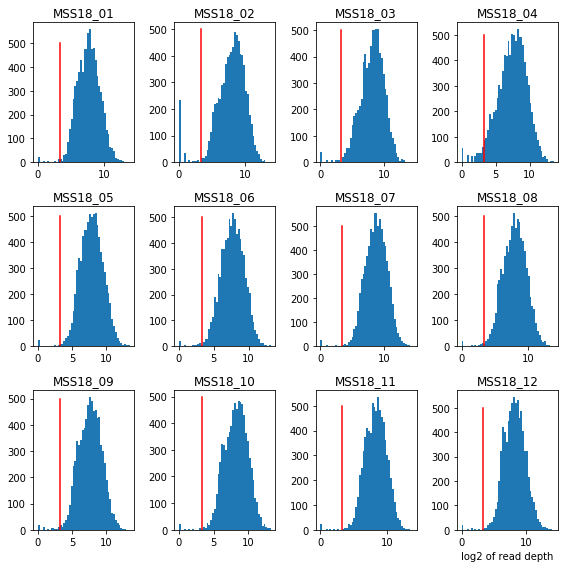

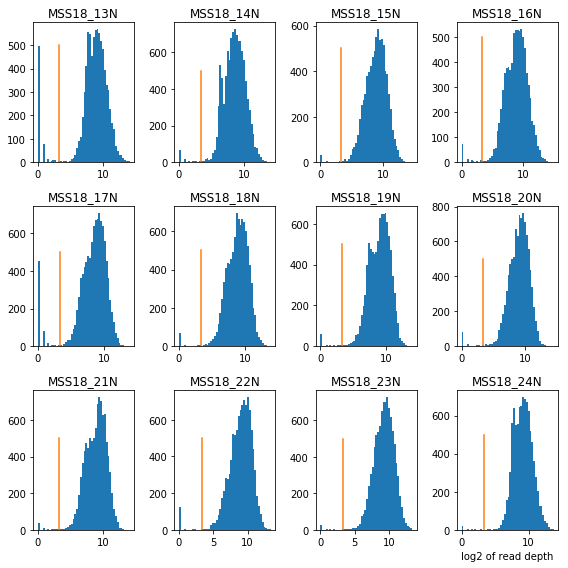

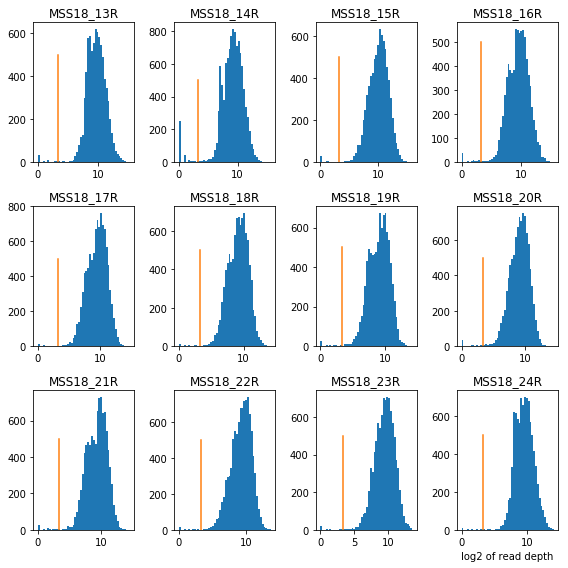

In [8]:
# histograms of readdepth
fig = plt.figure(figsize=(8,8))
Core_Xvalue ='MSS18'
Binlist = ['01','02','03','04','05','06','07','08','09','10','11','12']    
for i, binnum in enumerate(Binlist):
    tempcol = '%s_%s'%(Core_Xvalue,binnum)
    indx =tempDF3[tempcol]>0
    if sum(indx) >10:
        plt.subplot(3,4,i+1)
        plt.title(tempcol)
        temp = tempDF3[indx]
        plt.hist(np.log2(temp[tempcol]),50)
        plt.plot(np.log2([readthreshold,readthreshold]),[0,500],c='r',label='Threshold for ReadDepth')

plt.xlabel('log2 of read depth')
plt.tight_layout()
plt.savefig('figures/'+Folder+'/MSS18_NextSeq_SeqDepth_1.pdf')
plt.show()

fig = plt.figure(figsize=(8,8))
Binlist = ['13','14','15','16','17','18','19','20','21','22','23','24']    
for i, binnum in enumerate(Binlist):
    tempcol = '%s_%sN'%(Core_Xvalue,binnum)
    indx =tempDF7[tempcol]>0
    if sum(indx) >10:
        plt.subplot(3,4,i+1)
        plt.title(tempcol)
        temp = tempDF7[indx]
        plt.hist(np.log2(temp[tempcol]),50)
        plt.plot(np.log2([readthreshold,readthreshold]),[0,500])

plt.xlabel('log2 of read depth')
plt.tight_layout()
plt.savefig('figures/'+Folder+'/MSS18_NextSeq_SeqDepth_2.pdf')
plt.show()

fig = plt.figure(figsize=(8,8))
Binlist = ['13','14','15','16','17','18','19','20','21','22','23','24']    
for i, binnum in enumerate(Binlist):
    tempcol = '%s_%sR'%(Core_Xvalue,binnum)
    indx =tempDF5[tempcol]>0
    if sum(indx) >10:
        plt.subplot(3,4,i+1)
        plt.title(tempcol)
        temp = tempDF5[indx]
        plt.hist(np.log2(temp[tempcol]),50)
        plt.plot(np.log2([readthreshold,readthreshold]),[0,500])

plt.xlabel('log2 of read depth')
plt.tight_layout()
plt.savefig('figures/'+Folder+'/MSS18_NextSeq_SeqDepth_3.pdf')
plt.show()


# tempDF5

# compare replicates before and after removal of outliers
- Row 1 compares the activities computed from averaging all BCs equally
- Row 2 compares the activities computed from first removing outlier barcodes and then averaging all BCs equally
- Row 3 compares the activities computed from megering the read counts from all the inlier barcodes and computing activity once

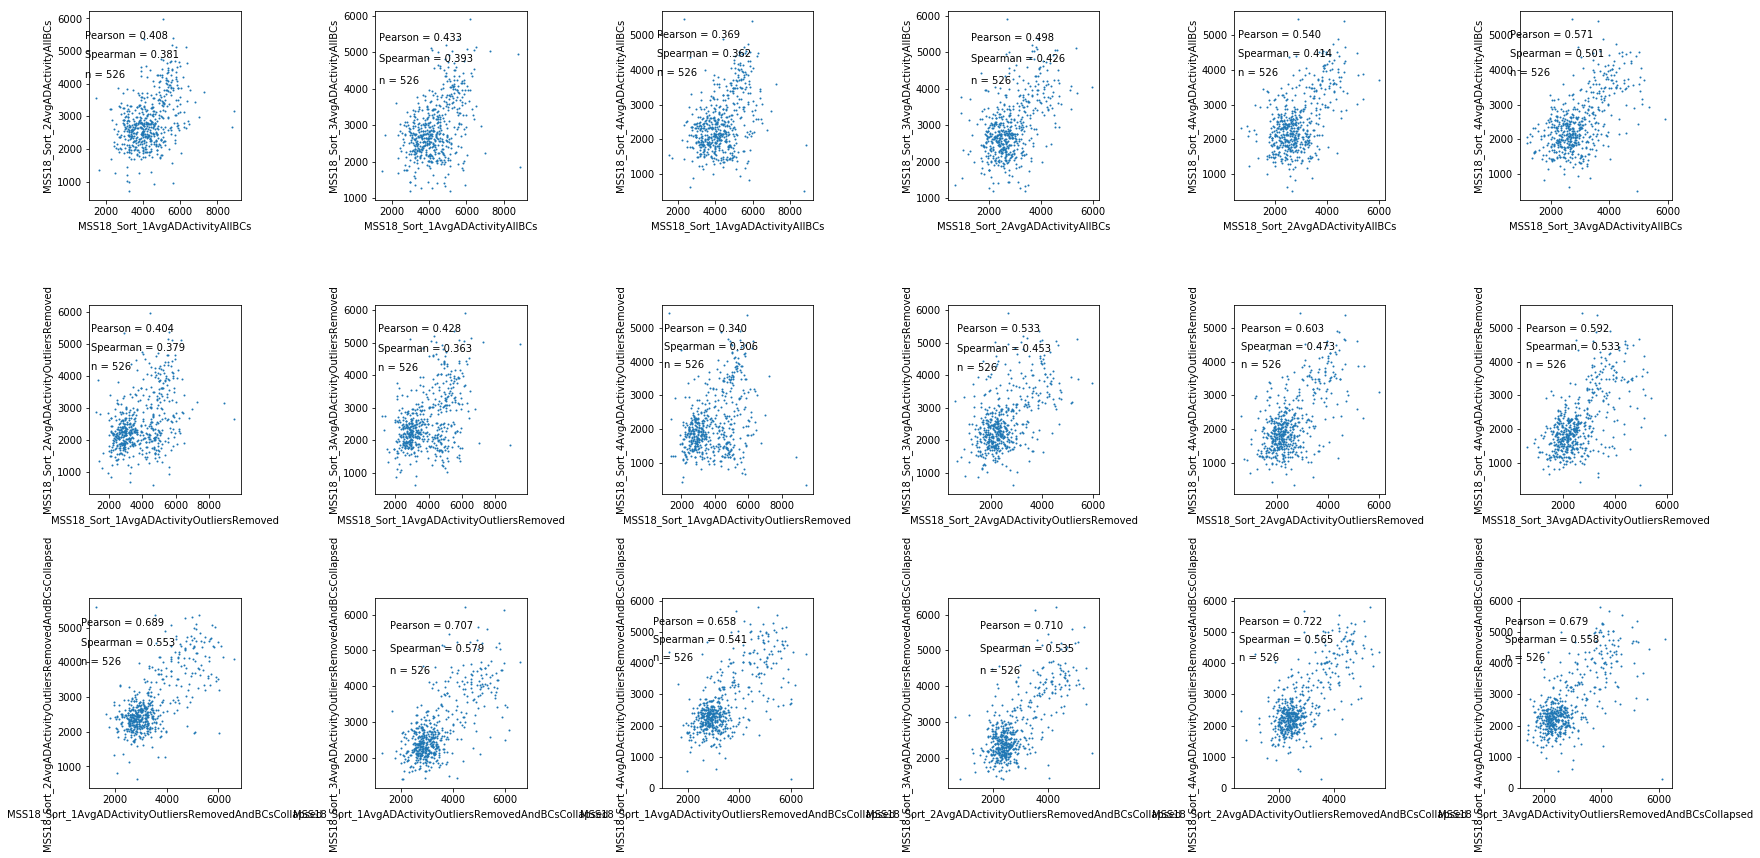

In [9]:
fig = plt.figure(figsize=(24,12))

Xset = [0,0,0,1,1,2]
Yset = [1,2,3,2,3,3]
MeasureType =[ColNames_AllBCs,ColNames_Filtered,ColNames_Merged]
for i in [0,1,2]: #row
    for j in [0,1,2,3,4,5]: #column
        X = AD_DF[ColNames_AllBCs[Xset[j]]]
        templist = MeasureType[i]
        X = AD_DF[templist[Xset[j]]]
        Y = AD_DF[templist[Yset[j]]]
        indx = (X>0) &(Y>0)
        X = X[indx]
        Y = Y[indx]
        plt.subplot(3,6,i*6+j+1)
        PF.plotScatter(X,Y,templist[Xset[j]],templist[Yset[j]],UseSetPresentinBoth=1)
plt.tight_layout()
plt.savefig('figures/'+Folder+'/CorrsBtwnPreprocessingStyles.pdf')
plt.show()

# Compare replicates, plot empty TF

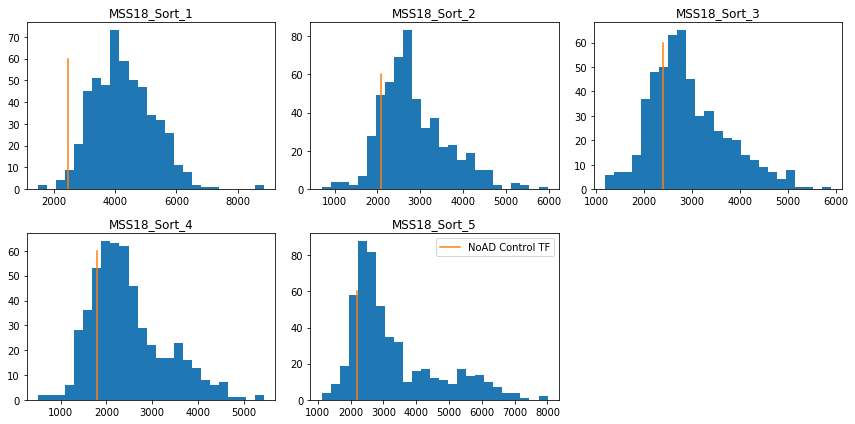

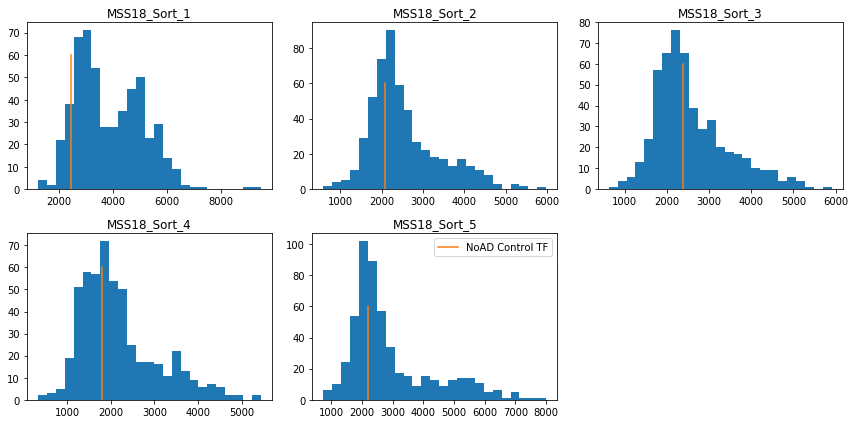

In [10]:
def plothists(ColList,Figname):
    fig = plt.figure(figsize=(12,6))

    for i, col in enumerate(ColList):
        plt.subplot(2,3,1+i)
        plt.hist(AD_DF[col],25)
        x = AD_DF[col][0]
        plt.plot([x,x],[0,60],label='NoAD Control TF')

        plt.title(ListofExperiments[i]) 
    plt.legend() 
    plt.tight_layout()
    plt.savefig('figures/'+Folder+'/'+Figname+'.pdf')
    plt.show()
# include all barcodes
plothists(ColNames_AllBCs,'ActivityHistograms_alldata')
plothists(ColNames_Filtered,'ActivityHistograms_RemoveOutliders')

## Replicate Reproducibility

['MSS18_Sort_1AvgADActivityOutliersRemovedAndBCsCollapsed', 'MSS18_Sort_2AvgADActivityOutliersRemovedAndBCsCollapsed', 'MSS18_Sort_3AvgADActivityOutliersRemovedAndBCsCollapsed', 'MSS18_Sort_4AvgADActivityOutliersRemovedAndBCsCollapsed', 'MSS18_Sort_5AvgADActivityOutliersRemovedAndBCsCollapsed']


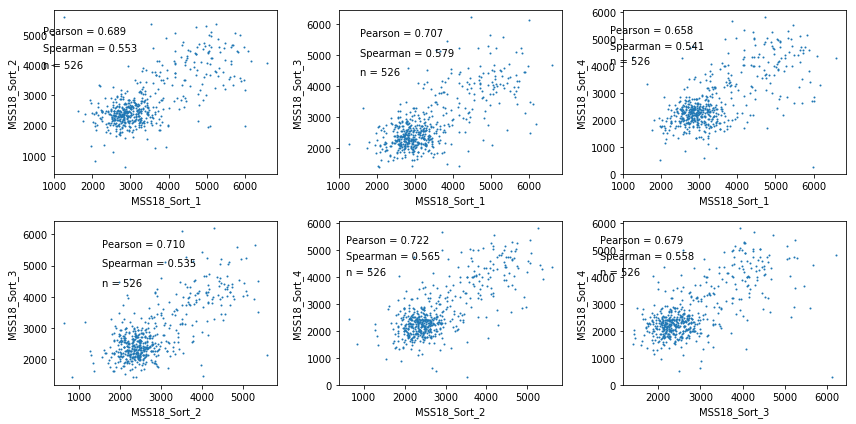

Average Pearson Correlation is: 0.694042


In [11]:
holdcorrs = []
Xset = [0,0,0,1,1,2]
Yset = [1,2,3,2,3,3]
MeasureType =[ColNames_AllBCs,ColNames_Filtered,ColNames_Merged]
for i in [2]: #row
    fig = plt.figure(figsize=(12,6))

    print MeasureType[i]
    for j in [0,1,2,3,4,5]: #column
        X = AD_DF[ColNames_AllBCs[Xset[j]]]
        templist = MeasureType[i]
        X = AD_DF[templist[Xset[j]]]
        Y = AD_DF[templist[Yset[j]]]
        indx = (X>0) &(Y>0)
        X = X[indx]
        Y = Y[indx]
        pearson = stats.pearsonr(X,Y)
        holdcorrs.append(pearson[0])
        plt.subplot(2,3,j+1)
        PF.plotScatter(X,Y,ListofExperiments[Xset[j]],ListofExperiments[Yset[j]],UseSetPresentinBoth=1)
plt.tight_layout()
plt.savefig('figures/'+Folder+'/BiologicalReplicates_CorrMergedActivites.pdf')
plt.show()
print 'Average Pearson Correlation is: %f' %np.mean(holdcorrs)

### Compare alternatives for merging BCs within each sample

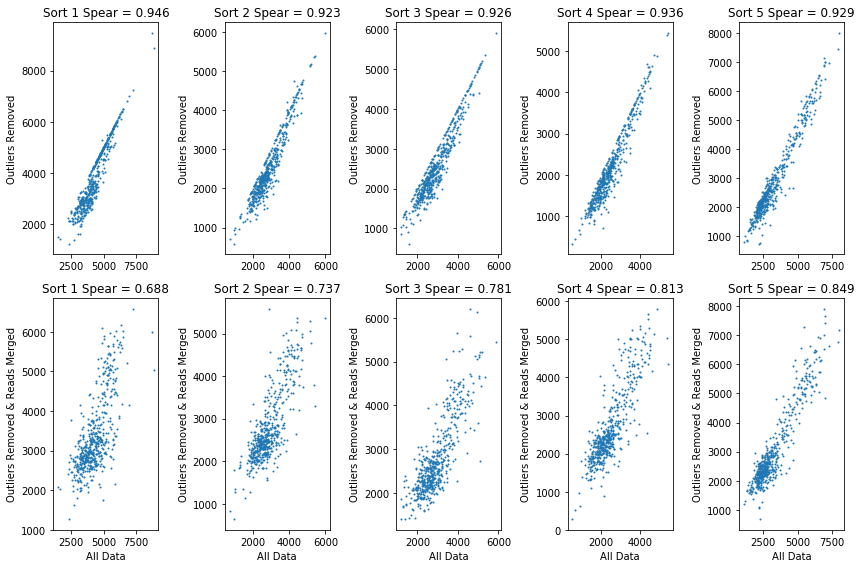

In [12]:
fig = plt.figure(figsize=(12,8))
for i,experiment in enumerate(ListofExperiments):
    plt.subplot(2,5,i+1)
    plt.scatter(AD_DF[experiment+'AvgADActivityAllBCs'],AD_DF[experiment+'AvgADActivityOutliersRemoved'],s=1)
    corr = scipy.stats.spearmanr(AD_DF[experiment+'AvgADActivityAllBCs'],AD_DF[experiment+'AvgADActivityOutliersRemoved'])
    plt.title('Sort %i Spear = %.3f'%(i+1,corr[0]))
    plt.ylabel('Outliers Removed')
    plt.subplot(2,5,i+6)
    plt.scatter(AD_DF[experiment+'AvgADActivityAllBCs'],AD_DF[experiment+'AvgADActivityOutliersRemovedAndBCsCollapsed'],s=1)
    corr = scipy.stats.spearmanr(AD_DF[experiment+'AvgADActivityAllBCs'],AD_DF[experiment+'AvgADActivityOutliersRemovedAndBCsCollapsed'])
    plt.title('Sort %i Spear = %.3f'%(i+1,corr[0]))
    plt.xlabel('All Data')
    plt.ylabel('Outliers Removed & Reads Merged')
plt.tight_layout()
# plt.savefig('figures/'+Folder+'/CorrsBtwnPreprocessingStyles_v1.pdf')
plt.show()

# Compare 2 methods for adding adaptors
Adding Illumina adaptors by PCR or adding adaptors by ligation does not meaningfully affect the data. A small handful of barcodes are missed by each method. These are technical replicates.

Note, that we only use the ligated adaptor data, for consistency

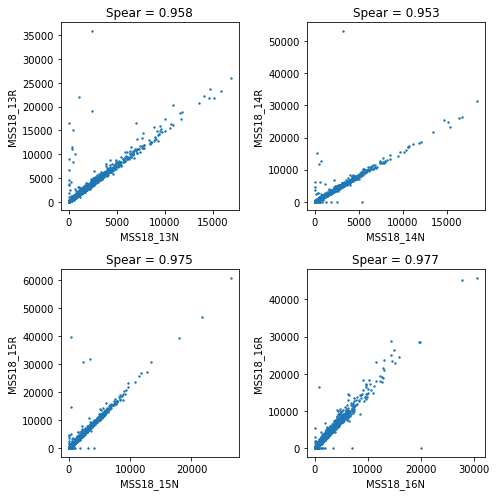

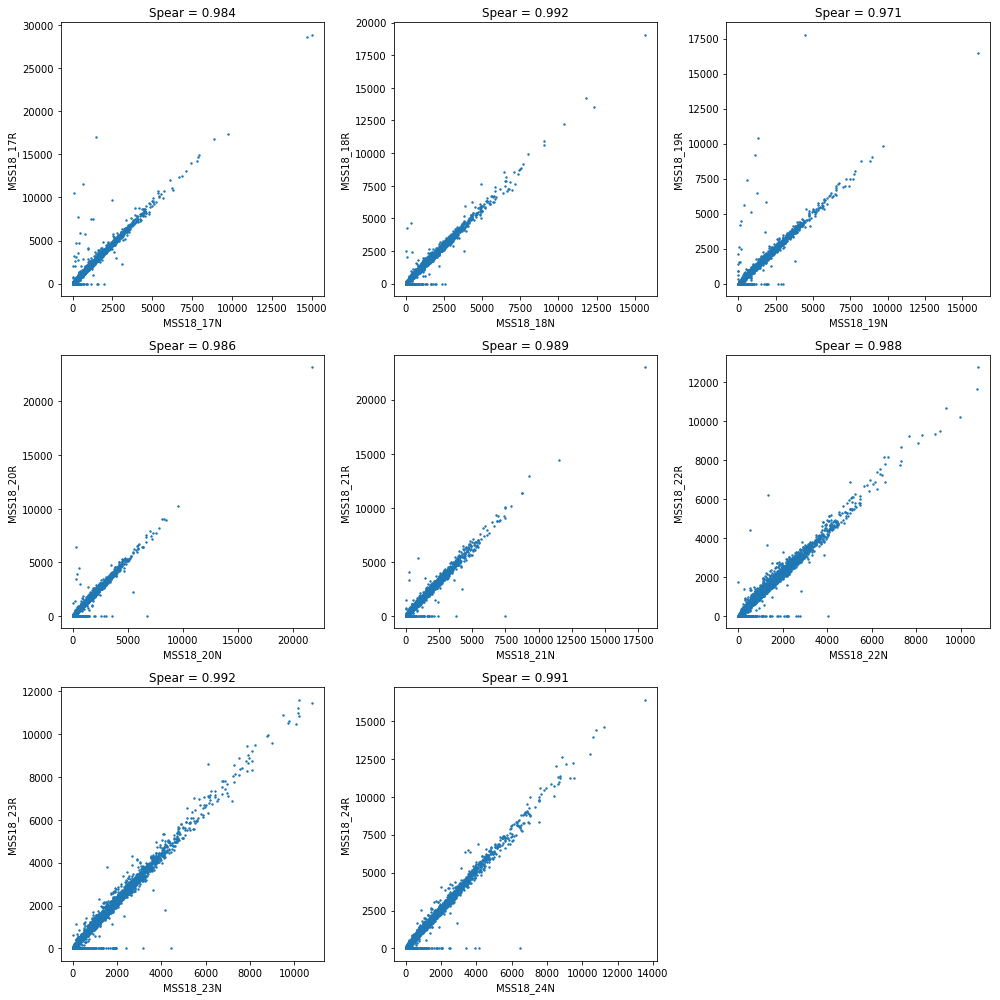

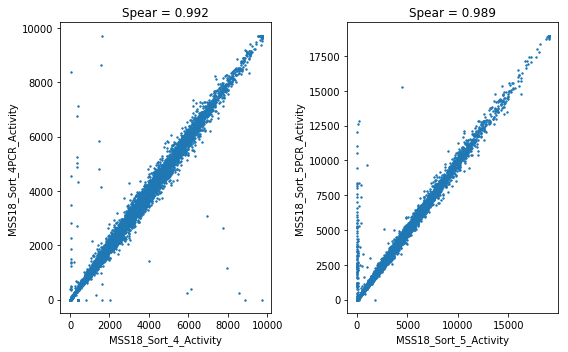

In [13]:
def plotscattersection(col1,col2):
    plt.scatter(tempDF7[col1],tempDF7[col2],s=2)
    corr = scipy.stats.pearsonr(tempDF7[col1],tempDF7[col2])
    plt.title('Spear = %.3f'%(corr[0]))
    plt.xlabel(col1),plt.ylabel(col2)

# compare raw reads
fig = plt.figure(figsize=(7,7))
for i, indx in enumerate([13,14,15,16]):
    plt.subplot(2,2,1+i)
    col1 = 'MSS18_%iN' %indx
    col2 = 'MSS18_%iR' %indx
    plotscattersection(col1,col2)
plt.tight_layout()
plt.savefig('figures/'+Folder+'/Sort4_corrRawReads.pdf')
plt.show()

fig = plt.figure(figsize=(14,14))
for i, indx in enumerate([17,18,19,20,21,22,23,24]):
    plt.subplot(3,3,1+i)
    col1 = 'MSS18_%iN' %indx
    col2 = 'MSS18_%iR' %indx
    plotscattersection(col1,col2)
plt.tight_layout()
plt.savefig('figures/'+Folder+'/Sort5_corrRawReads.pdf')
plt.show()

# # compare Activities

fig = plt.figure(figsize=(8,5))
for i, indx in enumerate([4,5]):
    plt.subplot(1,2,1+i)
    col1 = 'MSS18_Sort_%i_Activity' %indx
    col2 = 'MSS18_Sort_%iPCR_Activity' %indx
    plotscattersection(col1,col2)
plt.tight_layout()
plt.savefig('figures/'+Folder+'/Sort4_corrActivities.pdf')
plt.show()



# Violin plots of Activities look at differences between Biological Replicates

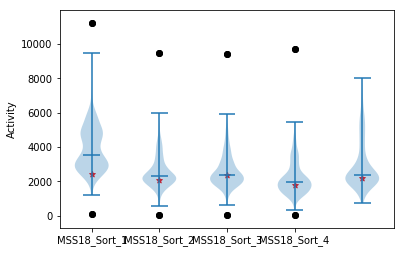

In [16]:
#

S1_BinValues = np.array([82.3,604,2037,11215]) #
S2_BinValues = np.array([56.5,489,1755,9456]) #
S3_BinValues = np.array([43.7,471,1750,9431]) #
S4_BinValues = np.array([41.2,386,1618,9716])
Xs =[1,1,2,2,3,3,4,4]
Ys =[82.3,11215,56.5,9456,43.7,9431,41.2,9716 ]
ActivityMeasurements = ColNames_Filtered
violinsets =[]
for i, activity in enumerate(ActivityMeasurements):
    tempactiviy = AD_DF[activity]
    tempactiviy=tempactiviy[tempactiviy.notnull()]
    violinsets.append(tempactiviy)
    plt.scatter(i+1,tempactiviy[0],c='r',marker='*')# the empty TF to the plot
plt.violinplot(violinsets,showmedians=True,)
plt.scatter(Xs,Ys,c='k') # plot the min and max bin vlues--theoretical maximm dynamic range
plt.scatter(Xs,Ys,c='k') # plot the min and max bin vlues--theoretical maximm dynamic range

plt.ylabel('Activity')
plt.xticks([1,2,3,4],ListofExperiments)
plt.savefig('figures/'+Folder+'/ViolinPlot_BioReplicates.pdf')
plt.show()


# Merging Biological Replicates using the No AD TF

The following section includes serveral different methods for merging the independent biological replicates.

815.375879551
548.901223049
1018.62071764
490.047716146
476.075923978


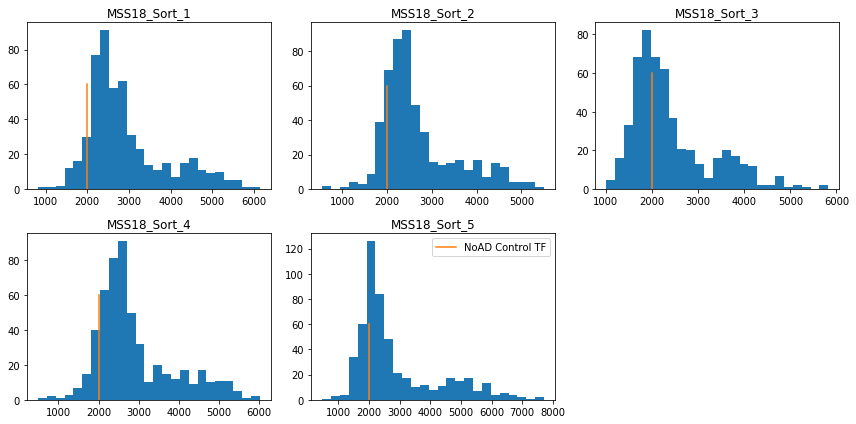

In [19]:
newcols = []
Columns2Normalize = ['MSS18_Sort_1AvgADActivityOutliersRemovedAndBCsCollapsed',
                     'MSS18_Sort_2AvgADActivityOutliersRemovedAndBCsCollapsed',
                     'MSS18_Sort_3AvgADActivityOutliersRemovedAndBCsCollapsed',
                     'MSS18_Sort_4AvgADActivityOutliersRemovedAndBCsCollapsed',
                     'MSS18_Sort_5AvgADActivityOutliersRemovedAndBCsCollapsed',
                    ]

for col in Columns2Normalize:
    AD_DF[col+'_NormToNoAD']=AD_DF[col]-AD_DF[col][0]+2000
    print min(AD_DF[col+'_NormToNoAD'])
    newcols.append(col+'_NormToNoAD')
plothists(newcols,'ActivityHistograms_RemoveOutliders_CenteronEmptyTF')
tempDF = AD_DF[newcols]

AD_DF['Activity_Mean_MSS18'] =tempDF.mean(axis=1)
AD_DF['Activity_std_MSS18'] =tempDF.std(axis=1)
AD_DF['Activity_SEM_MSS18'] = tempDF.std(axis=1)/2
AD_DF.to_pickle('pickleFiles/NormalizedData/MSS18_AD_DF_FluorValues_NextSeq20210722_NormToNoAD')




# Merging Biological replicates with Z scores


MSS18_Sort_1AvgADActivityOutliersRemovedAndBCsCollapsed 	mean = 3373.225 	sigma = 953.644
MSS18_Sort_2AvgADActivityOutliersRemovedAndBCsCollapsed 	mean = 2780.631 	sigma = 836.575
MSS18_Sort_3AvgADActivityOutliersRemovedAndBCsCollapsed 	mean = 2792.389 	sigma = 863.691
MSS18_Sort_4AvgADActivityOutliersRemovedAndBCsCollapsed 	mean = 2677.533 	sigma = 965.406
MSS18_Sort_5AvgADActivityOutliersRemovedAndBCsCollapsed 	mean = 3074.107 	sigma = 1359.223


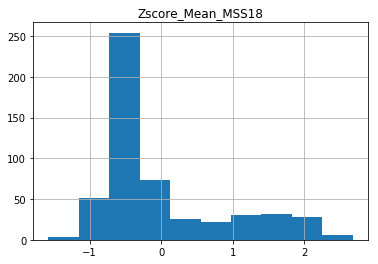

In [23]:
# for each Biological replicate find the global mean and standard deviation (Sigma)
# for each measurment, convert the raw activity into a Z score 
# Z score = (raw measurment - mean)/sigma
AD_DF_Zscores = pd.DataFrame({'ADseq':AD_DF.ADseq})
tempcols =[]
for activity in ColNames_Merged:
    colmean = np.mean(AD_DF[activity])
    colsigma = np.std(AD_DF[activity])
    print '%s \tmean = %.3f \tsigma = %.3f'%(activity,colmean,colsigma)
    tempZs = (AD_DF[activity]-colmean)/colsigma
    AD_DF[activity+'_Zscore']=tempZs
    tempcols.append(activity+'_Zscore')
tempDF = AD_DF[tempcols]
AD_DF['Zscore_Mean_MSS18'] = tempDF.mean(axis=1)
AD_DF['Zscore_SEM_MSS18'] = tempDF.std(axis=1)/ np.sqrt(len(tempcols))

## export the dataframes
AD_DF.to_pickle('pickleFiles/NormalizedData/MSS18_AD_DF_FluorValues_NextSeq20210722_NormToNoAD_wZscores')

AD_DF.hist(column='Zscore_Mean_MSS18')
plt.show()

# plot 8 bin sort vs Combined 4 bin sorts

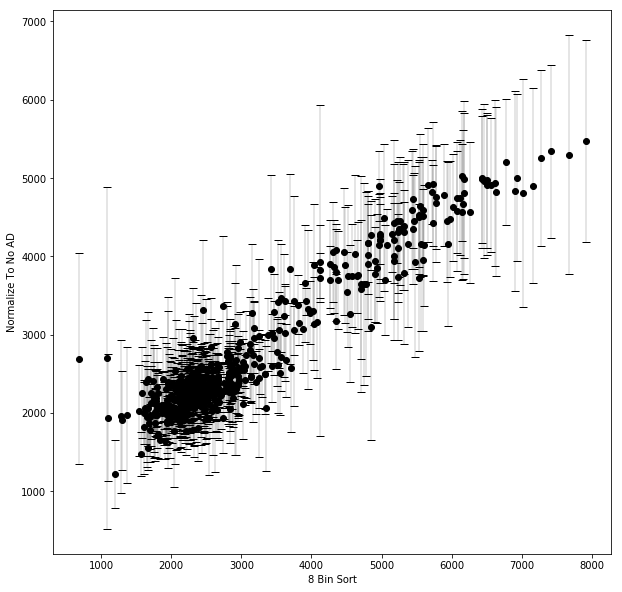

,Activity_Mean_MSS18,Activity_Mean_MSS18
Activity_Mean_MSS18,1.000000,1.000000
Activity_std_MSS18,0.595938,0.595938
MSS18_S5_8bins,0.956293,0.956293


In [24]:
Xs = AD_DF.MSS18_Sort_5AvgADActivityOutliersRemovedAndBCsCollapsed#8 bin data
Ys =  AD_DF['Activity_Mean_MSS18'] #mean 4bin data
Yerrs = AD_DF['Activity_std_MSS18']#SEM of combined 4 replicates
fig = plt.figure(figsize=(10,10))

tempDF = AD_DF[['ADseq','Activity_Mean_MSS18','Activity_std_MSS18']]
tempDF['MSS18_S5_8bins']=  AD_DF.MSS18_Sort_5AvgADActivityOutliersRemovedAndBCsCollapsed
tempDF.to_pickle('pickleFiles/NormalizedData/MSS18_AD_DF_Zscores_AND_Sort5mean')

plt.errorbar(Xs,Ys,yerr=Yerrs,fmt='o',capsize=4, elinewidth=.2,c='k')
plt.xlabel('8 Bin Sort'),plt.ylabel('Normalize To No AD')
plt.savefig('figures/'+Folder+'/Compare_8_binSort5_Zscores_errorBars.pdf')
plt.show()

a = tempDF.corr()
a[[0,0]]

### Activity is not correlated with number of barcodes recovered

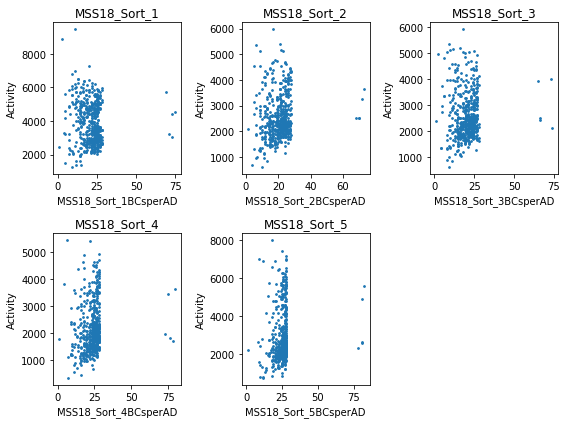

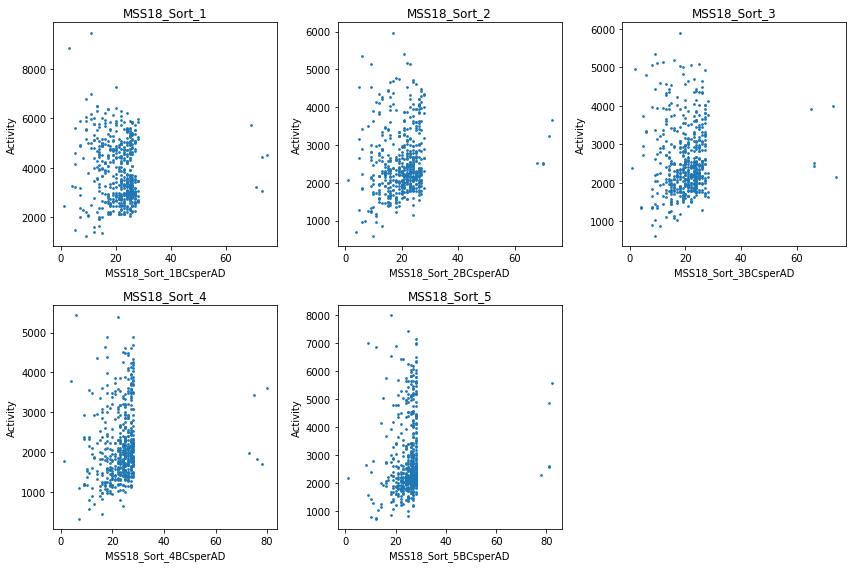

In [25]:
# how does activity correlate with # of BCs
fig = plt.figure(figsize=(8,6))
CurrentDF = AD_DF
for i, activity in enumerate(ActivityMeasurements):
    plt.subplot(2,3,i+1)
    tempcol = activity[:12]+'BCsperAD'
    plt.scatter(CurrentDF[tempcol],CurrentDF[activity],s=3)
    plt.ylabel('Activity'),plt.xlabel(tempcol),plt.title(activity[:12])
plt.tight_layout()
plt.savefig('figures/'+Folder+'/Activity_vs_BCnumber.pdf')
plt.show()
fig = plt.figure(figsize=(12,8))
CurrentDF = AD_DF
for i, activity in enumerate(ActivityMeasurements):
    plt.subplot(2,3,i+1)
    tempcol = activity[:12]+'BCsperAD'
    plt.scatter(CurrentDF[tempcol],CurrentDF[activity],s=3)
    plt.ylabel('Activity'),plt.xlabel(tempcol),plt.title(activity[:12])
plt.tight_layout()
plt.savefig('figures/'+Folder+'/Activity_vs_BCnumber.pdf')
plt.show()

# Reprocess the p53 data using the new BC merging and Z score methods

In [3]:
#load in the design file for the p53 DMS dataset
p53DMS_DF = pd.read_pickle('../../Analysis_LC1_p53DMS/BuildSupportDataFrame/p53_Array1_withProperties_DataFrame_20190125')
p53DMS_DF = p53DMS_DF[['ADseq','Barcode']]
p53DMS_DF.loc[len(p53DMS_DF.index)] = ['', 'ATCGATCGA', ] 

# DesignedBCs_p53 = list(LegacyDF_original.Barcode)
p53DMS_DF

,ADseq,Barcode
0,EEPQSDPSVEPPLSQETFSDAWKLLAENNVLSPLPSQAM,AACAACAACACC
1,EEPQSDPSVEPPLSQETFSDAWKLLAENNVLSPLPSQAM,AACAACAACGGT
2,EEPQSDPSVEPPLSQETFSDAWKLLAENNVLSPLPSQAM,AACAACACAAGC
3,EEPQSDPSVEPPLSQETFSDAWKLLAENNVLSPLPSQAM,AACAACACCTCA
4,EEPQSDPSVEPPLSQETFSDAWKLLAENNVLSPLPSQAM,AACAACAGAGTC
5,EEPQSDLSIEPPLSQETFSDLWNLLPENNVLSPVLSPPM,AACAACAGCCGA
6,EEPQSDLSIEPPLSQETFSDLWNLLPENNVLSPVLSPPM,AACAACATGGAC
7,EEPQSDLSIEPPLSQETFSDLWNLLPENNVLSPVLSPPM,AACAACATTCGC
8,EEPQSDLSIEPPLSQETFSDLWNLLPENNVLSPVLSPPM,AACAACCACTGA
9,EEPQSDLSIEPPLSQETFSDLWNLLPENNVLSPVLSPPM,AACAACCATCCA


In [4]:
readthreshold = 10

# p53 DMS library replicate 3 MSS17 sorted: August 2019
ExpName = 'MSS17_Sort1_nextseq' # 
numPCRs =8
BinValues = np.array([31.31]*numPCRs+[46.05]*numPCRs+[56.87]*numPCRs+[66.25]*numPCRs+[79.55]*numPCRs+[99.71]*numPCRs+[146.61]*numPCRs+[329.44]*numPCRs) # use GFP 
data_dir = '../../Data/MSS17/nextseq/' # 


p53DF1,p53AD_DF1 = processReadCounts_v2(ExpName,data_dir,BinValues,readthreshold,removeOutliers=True,DesignDF=p53DMS_DF)
p53DF1.to_pickle('../../Data/reprocess_p53_June2021/%s_%i'%(ExpName,readthreshold))
p53AD_DF1.shape

Design file contains 14999 barcodes and 2992 ADs
../../Data/MSS17/nextseq/MSS17_1_A.txtsorted.txt has 56995 unique sequences
4711925 reads with 4445893 matching designed BCs
9615 BC matches containing 94.4 percent of reads
../../Data/MSS17/nextseq/MSS17_1_B.txtsorted.txt has 44225 unique sequences
3042359 reads with 2867424 matching designed BCs
9585 BC matches containing 94.3 percent of reads
../../Data/MSS17/nextseq/MSS17_1_C.txtsorted.txt has 46989 unique sequences
3184250 reads with 3000085 matching designed BCs
9694 BC matches containing 94.2 percent of reads
../../Data/MSS17/nextseq/MSS17_1_D.txtsorted.txt has 50153 unique sequences
3230248 reads with 3039432 matching designed BCs
9879 BC matches containing 94.1 percent of reads
../../Data/MSS17/nextseq/MSS17_1_E.txtsorted.txt has 63327 unique sequences
4780570 reads with 4488743 matching designed BCs
9787 BC matches containing 93.9 percent of reads
../../Data/MSS17/nextseq/MSS17_1_F.txtsorted.txt has 56994 unique sequences
43996

(2992, 6)

In [5]:
# replicate 2
# p53 DMS library replicate 2, technical replicate 2, MSS16 sorted: August 2019
ExpName = 'MSS16_Sort1' # 
numPCRs =1
# BinValues = np.array([1]*numPCRs+[2]*numPCRs+[3]*numPCRs+[4]) # 
BinValues = np.array([3.54]*numPCRs+[5.46]*numPCRs+[8.12]*numPCRs+[25.81]) # use GFP 
data_dir = '../../Data/MSS16/nextseq/Sort1/' 
p53DF2,p53AD_DF2 = processReadCounts_v2(ExpName,data_dir,BinValues,readthreshold,removeOutliers=True,DesignDF=p53DMS_DF)
p53DF2.to_pickle('../../Data/reprocess_p53_June2021/%s_%i'%(ExpName,readthreshold))



Design file contains 14999 barcodes and 2992 ADs
../../Data/MSS16/nextseq/Sort1/MSS16_01.txtsorted.txt has 142409 unique sequences
20914122 reads with 19372207 matching designed BCs
10329 BC matches containing 92.6 percent of reads
../../Data/MSS16/nextseq/Sort1/MSS16_02.txtsorted.txt has 138122 unique sequences
23335739 reads with 21850631 matching designed BCs
11066 BC matches containing 93.6 percent of reads
../../Data/MSS16/nextseq/Sort1/MSS16_03.txtsorted.txt has 128442 unique sequences
21700739 reads with 20533130 matching designed BCs
11308 BC matches containing 94.6 percent of reads
../../Data/MSS16/nextseq/Sort1/MSS16_04.txtsorted.txt has 109977 unique sequences
17569599 reads with 16458276 matching designed BCs
10282 BC matches containing 93.7 percent of reads

In total, 12862 designed barcodes were found in this experiment
There are 12635 Barcodes with more than 10 reads
There are 227 Barcodes with <= 10 reads

['MSS16_01_norm1', 'MSS16_02_norm1', 'MSS16_03_norm1', 'MSS16_04

In [6]:
# replicate 1
# p53 DMS library replicate 1 MSS11 sorted: spring 2019
ExpName = 'MSS11_NextSeq3_Sort4_manyPCRs' # 
data_dir = '../../Data/MSS11/NextSeq3_PoolC/Sort4/' 
numPCRs =23
BinValues = np.array([6.59]*numPCRs+[25.08]*numPCRs+ [53.95]*numPCRs+ [141.3]*numPCRs) # using the median of the GFP


p53DF3,p53AD_DF3 = processReadCounts_v2(ExpName,data_dir,BinValues,readthreshold,removeOutliers=True,DesignDF=p53DMS_DF)
p53DF3.to_pickle('../../Data/reprocess_p53_June2021/%s_%i'%(ExpName,readthreshold))


Design file contains 14999 barcodes and 2992 ADs
../../Data/MSS11/NextSeq3_PoolC/Sort4/MSS11_13_C.txtsorted.txt has 25728 unique sequences
3755088 reads with 3519790 matching designed BCs
1970 BC matches containing 93.7 percent of reads
../../Data/MSS11/NextSeq3_PoolC/Sort4/MSS11_13_D.txtsorted.txt has 15619 unique sequences
1932944 reads with 1817258 matching designed BCs
2046 BC matches containing 94.0 percent of reads
../../Data/MSS11/NextSeq3_PoolC/Sort4/MSS11_13_E.txtsorted.txt has 5663 unique sequences
567464 reads with 533116 matching designed BCs
1883 BC matches containing 93.9 percent of reads
../../Data/MSS11/NextSeq3_PoolC/Sort4/MSS11_13_F.txtsorted.txt has 21929 unique sequences
2839340 reads with 2671109 matching designed BCs
2239 BC matches containing 94.1 percent of reads
../../Data/MSS11/NextSeq3_PoolC/Sort4/MSS11_13_G.txtsorted.txt has 6043 unique sequences
329825 reads with 309077 matching designed BCs
2348 BC matches containing 93.7 percent of reads
../../Data/MSS11/

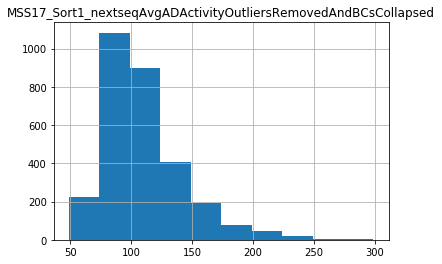

empty TF activity is: 70.968916


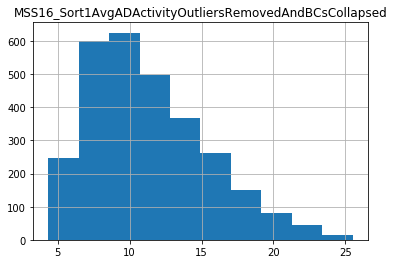

empty TF activity is: 9.382469


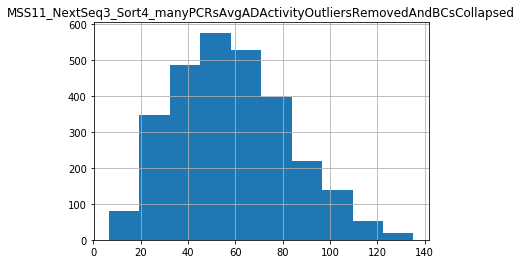

empty TF activity is: 11.773557


In [7]:
p53AD_DF1.hist(column = 'MSS17_Sort1_nextseqAvgADActivityOutliersRemovedAndBCsCollapsed')
plt.show()
print 'empty TF activity is: %f' %p53AD_DF1['MSS17_Sort1_nextseqAvgADActivityOutliersRemovedAndBCsCollapsed'][0]

p53AD_DF2.hist(column = 'MSS16_Sort1AvgADActivityOutliersRemovedAndBCsCollapsed')
plt.show()
print 'empty TF activity is: %f' %p53AD_DF2['MSS16_Sort1AvgADActivityOutliersRemovedAndBCsCollapsed'][0]

p53AD_DF3.hist(column = 'MSS11_NextSeq3_Sort4_manyPCRsAvgADActivityOutliersRemovedAndBCsCollapsed')
plt.show()
print 'empty TF activity is: %f' %p53AD_DF3['MSS11_NextSeq3_Sort4_manyPCRsAvgADActivityOutliersRemovedAndBCsCollapsed'][0]


In [8]:
p53AD_DF2

,ADseq,MSS16_Sort1AvgADActivityAllBCs,MSS16_Sort1AvgADActivityOutliersRemoved,MSS16_Sort1AvgADActivityOutliersRemovedAndBCsCollapsed,MSS16_Sort1BCsperAD,MSS16_Sort1BCsperADOutliersRemoved
0,,9.382469,9.382469,9.382469,1,1
1,EEPQSDPSVEPPLSQETFSDAWKLLAENNVLSPLPSQAM,13.459868,13.459868,8.317909,4,4
2,DDLMASPDDIEQAFTEDPGPD,11.903283,11.903283,7.226626,4,4
3,DDLMLSPDDIEQWFTEDPGRD,13.716229,13.716229,6.636712,3,3
4,EEPQSDLSIEPPLSQETFSDLWNLLPENNVLSPVLSPPM,10.978823,10.978823,9.631509,4,4
5,EEPQSDPSVEPPLSQETFSDLWKDLPENNVLSPLPSQAM,16.463330,16.463330,17.678856,4,4
6,EEPQSDPSVEPPLSQETFSDAWKLLPENNVLSALPSQAM,12.665486,12.665486,9.741686,5,5
7,DDLMLSPDSIEQWFTEDPGPD,NaN,NaN,NaN,0,0
8,DDLMLSPDDEEEWFTEDPGPD,7.031749,7.031749,6.399474,3,3
9,GSGMAQSTATSPDGGTTFSDLWSSLEPDSTYFDLPQSSR,23.696734,NaN,NaN,1,0


In [9]:
# combine Dataframes
AD_DF_p53 = pd.merge(p53AD_DF1, p53AD_DF2, left_index=True, right_index=True, how='outer')
AD_DF_p53 = pd.merge(AD_DF_p53, p53AD_DF3, left_index=True, right_index=True, how='outer')
AD_DF_p53.shape

(2992, 18)

Index([u'ADseq_x', u'MSS17_Sort1_nextseqAvgADActivityAllBCs',
       u'MSS17_Sort1_nextseqAvgADActivityOutliersRemoved',
       u'MSS17_Sort1_nextseqAvgADActivityOutliersRemovedAndBCsCollapsed',
       u'MSS17_Sort1_nextseqBCsperAD',
       u'MSS17_Sort1_nextseqBCsperADOutliersRemoved', u'ADseq_y',
       u'MSS16_Sort1AvgADActivityAllBCs',
       u'MSS16_Sort1AvgADActivityOutliersRemoved',
       u'MSS16_Sort1AvgADActivityOutliersRemovedAndBCsCollapsed',
       u'MSS16_Sort1BCsperAD', u'MSS16_Sort1BCsperADOutliersRemoved', u'ADseq',
       u'MSS11_NextSeq3_Sort4_manyPCRsAvgADActivityAllBCs',
       u'MSS11_NextSeq3_Sort4_manyPCRsAvgADActivityOutliersRemoved',
       u'MSS11_NextSeq3_Sort4_manyPCRsAvgADActivityOutliersRemovedAndBCsCollapsed',
       u'MSS11_NextSeq3_Sort4_manyPCRsBCsperAD',
       u'MSS11_NextSeq3_Sort4_manyPCRsBCsperADOutliersRemoved',
       u'MSS17_Sort1_nextseqAvgADActivityOutliersRemovedAndBCsCollapsed_NormToNoAD',
       u'MSS11_NextSeq3_Sort4_manyPCRsAvgADActivit

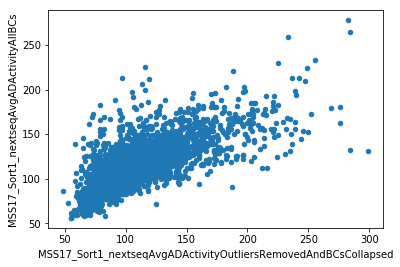

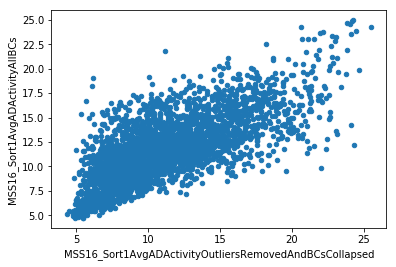

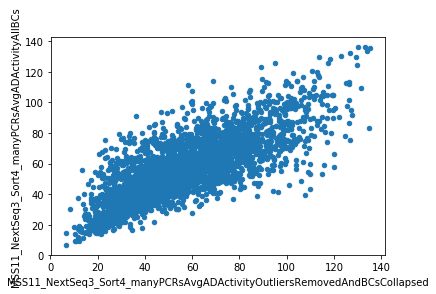

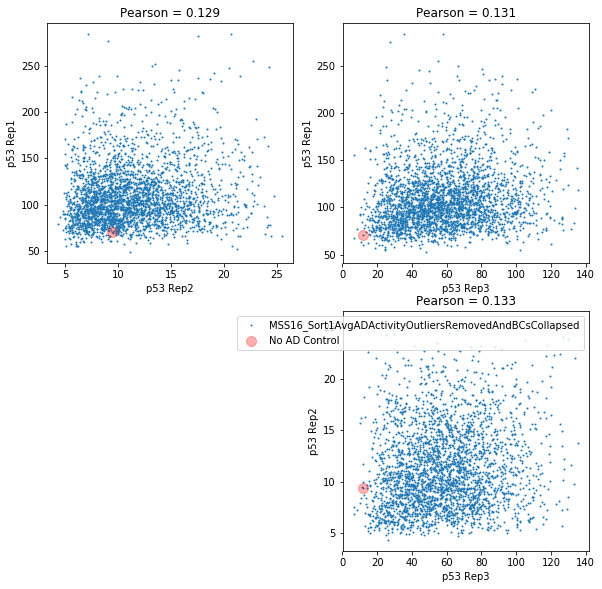

(0.1332630181854764, 1.7295784695577204e-12)

In [14]:
print AD_DF_p53.columns

Activities_p53_DMS =['MSS17_Sort1_nextseqAvgADActivityOutliersRemovedAndBCsCollapsed',
                     'MSS16_Sort1AvgADActivityOutliersRemovedAndBCsCollapsed',
                    'MSS11_NextSeq3_Sort4_manyPCRsAvgADActivityOutliersRemovedAndBCsCollapsed']
RenameColDict ={'MSS17_Sort1_nextseqAvgADActivityOutliersRemovedAndBCsCollapsed':'p53 Rep1',
 'MSS16_Sort1AvgADActivityOutliersRemovedAndBCsCollapsed':'p53 Rep2',
 'MSS11_NextSeq3_Sort4_manyPCRsAvgADActivityOutliersRemovedAndBCsCollapsed':'p53 Rep3'}

Activities_p53_DMS_all_BCs =['MSS17_Sort1_nextseqAvgADActivityAllBCs',
                            'MSS16_Sort1AvgADActivityAllBCs',
                            'MSS11_NextSeq3_Sort4_manyPCRsAvgADActivityAllBCs']
for i in np.arange(0,3):
    AD_DF_p53.plot.scatter(Activities_p53_DMS[i],Activities_p53_DMS_all_BCs[i])
    plt.show()
fig = plt.figure(figsize=(15,15))

plotset = Activities_p53_DMS
for i in np.arange(0,3):
    for j in np.arange(0,3):
        if j<i:
            plt.subplot(3,3,1+i+j*3)
            x,y = plotset[i],plotset[j]
            a = AD_DF_p53[x]
            b = AD_DF_p53[y]
            indx = (a>0)&(b>0)
            a = a[indx]
            b = b[indx]
            plt.scatter(a,b,s=1)
            plt.scatter(a[0],b[0],c='r',s=100,alpha=.3,label='No AD Control')
            plt.xlabel(RenameColDict[x]), plt.ylabel(RenameColDict[y])
            corr = stats.pearsonr(a,b)
            plt.title('Pearson = %.3f'%corr[0])
plt.legend()
plt.show()
corr

#### Merge Replicates 1 and 3 with the No AD TF

In [18]:
newcols = []
Columns2Normalize = [
                    'MSS17_Sort1_nextseqAvgADActivityOutliersRemovedAndBCsCollapsed',
#                      'MSS16_Sort1AvgADActivityOutliersRemovedAndBCsCollapsed',
                    'MSS11_NextSeq3_Sort4_manyPCRsAvgADActivityOutliersRemovedAndBCsCollapsed'
                    ]
def plothists(ColList,Figname):
    fig = plt.figure(figsize=(12,6))

    for i, col in enumerate(ColList):
        plt.subplot(2,3,1+i)
        plt.hist(AD_DF_p53[col],25)
        x = AD_DF_p53[col][0]
        plt.plot([x,x],[0,60],label='NoAD Control TF')

#         plt.title('Replicate ') 
    plt.legend() 
    plt.tight_layout()
    plt.savefig('figures/'+Folder+'/'+Figname+'.pdf')
    plt.show()
    

for col in Columns2Normalize:
    AD_DF_p53[col+'_NormToNoAD']=AD_DF_p53[col]-AD_DF_p53[col][0]+100
    print min(AD_DF_p53[col+'_NormToNoAD'])
    newcols.append(col+'_NormToNoAD')
# plothists(newcols,'ActivityHistograms_RemoveOutliders_CenteronEmptyTF')
tempDF = AD_DF_p53[newcols]

AD_DF_p53['Activity_Mean_NormToNoAD'] =tempDF.mean(axis=1)
AD_DF_p53['Activity_std_NormToNoAD'] =tempDF.std(axis=1)




77.9500300143
94.8164433035


#### Merge all three replicates with Z scores

In [19]:
# for each Biological replicate find the global mean and standard deviation (Sigma)
# for each measurment, convert the raw activity into a Z score 
# Z score = (raw measurment - mean)/sigma
# AD_DF_Zscores_p53 = pd.DataFrame({'ADseq':AD_DF_p53.ADseq})

tempcols =[]
for activity in Activities_p53_DMS:
    colmean = np.mean(AD_DF_p53[activity])
    colsigma = np.std(AD_DF_p53[activity])
    print '%s \tmean = %.3f \tsigma = %.3f'%(activity,colmean,colsigma)
    tempZs = (AD_DF_p53[activity]-colmean)/colsigma
    AD_DF_p53[activity+'_Zscore']=tempZs
    tempcols.append(activity+'_Zscore')
tempDF = AD_DF_p53[tempcols]
AD_DF_p53['Zscore_Mean_p53'] = tempDF.mean(axis=1)
AD_DF_p53['Zscore_SEM_p53'] = tempDF.std(axis=1)/ np.sqrt(len(tempcols))

MSS17_Sort1_nextseqAvgADActivityOutliersRemovedAndBCsCollapsed 	mean = 110.138 	sigma = 33.810
MSS16_Sort1AvgADActivityOutliersRemovedAndBCsCollapsed 	mean = 11.311 	sigma = 4.029
MSS11_NextSeq3_Sort4_manyPCRsAvgADActivityOutliersRemovedAndBCsCollapsed 	mean = 58.362 	sigma = 23.972


In [20]:
## export the dataframe
AD_DF_p53.to_pickle('../../Data/reprocess_p53_June2021/p53_DMS_Reprocessed_3Bioreplicates_MergeBCs_20210730')


In [17]:
AD_DF_p53

,ADseq_x,MSS17_Sort1_nextseqAvgADActivityAllBCs,MSS17_Sort1_nextseqAvgADActivityOutliersRemoved,MSS17_Sort1_nextseqAvgADActivityOutliersRemovedAndBCsCollapsed,MSS17_Sort1_nextseqBCsperAD,MSS17_Sort1_nextseqBCsperADOutliersRemoved,ADseq_y,MSS16_Sort1AvgADActivityAllBCs,MSS16_Sort1AvgADActivityOutliersRemoved,MSS16_Sort1AvgADActivityOutliersRemovedAndBCsCollapsed,...,MSS11_NextSeq3_Sort4_manyPCRsBCsperADOutliersRemoved,MSS17_Sort1_nextseqAvgADActivityOutliersRemovedAndBCsCollapsed_NormToNoAD,MSS11_NextSeq3_Sort4_manyPCRsAvgADActivityOutliersRemovedAndBCsCollapsed_NormToNoAD,Activity_Mean_NormToNoAD,Activity_std_NormToNoAD,MSS17_Sort1_nextseqAvgADActivityOutliersRemovedAndBCsCollapsed_Zscore,MSS16_Sort1AvgADActivityOutliersRemovedAndBCsCollapsed_Zscore,MSS11_NextSeq3_Sort4_manyPCRsAvgADActivityOutliersRemovedAndBCsCollapsed_Zscore,Zscore_Mean_p53,Zscore_SEM_p53
0,,70.968916,70.968916,70.968916,1,1,,9.382469,9.382469,9.382469,...,1,100.000000,100.000000,100.000000,0.000000,-1.158510,-0.478641,-1.943483,-1.193545,0.423226
1,EEPQSDPSVEPPLSQETFSDAWKLLAENNVLSPLPSQAM,122.987957,122.987957,136.853103,5,5,EEPQSDPSVEPPLSQETFSDAWKLLAENNVLSPLPSQAM,13.459868,13.459868,8.317909,...,5,165.884187,135.232186,150.558186,21.674238,0.790136,-0.742873,-0.473731,-0.142156,0.472577
2,DDLMASPDDIEQAFTEDPGPD,113.401838,113.401838,80.608316,4,4,DDLMASPDDIEQAFTEDPGPD,11.903283,11.903283,7.226626,...,3,109.639400,133.533122,121.586261,16.895413,-0.873407,-1.013738,-0.544609,-0.810585,0.139021
3,DDLMLSPDDIEQWFTEDPGRD,156.402919,156.402919,164.011116,4,4,DDLMLSPDDIEQWFTEDPGRD,13.716229,13.716229,6.636712,...,3,193.042200,187.374335,190.208267,4.007786,1.593384,-1.160159,1.701440,0.711555,0.936377
4,EEPQSDLSIEPPLSQETFSDLWNLLPENNVLSPVLSPPM,119.644061,119.644061,113.258239,5,5,EEPQSDLSIEPPLSQETFSDLWNLLPENNVLSPVLSPPM,10.978823,10.978823,9.631509,...,4,142.289323,149.991905,146.140614,5.446548,0.092274,-0.416828,0.141988,-0.060855,0.178564
5,EEPQSDPSVEPPLSQETFSDLWKDLPENNVLSPLPSQAM,87.893271,87.893271,82.623350,5,5,EEPQSDPSVEPPLSQETFSDLWKDLPENNVLSPLPSQAM,16.463330,16.463330,17.678856,...,3,111.654434,118.401179,115.027806,4.770669,-0.813809,1.580586,-1.175856,-0.136360,0.864811
6,EEPQSDPSVEPPLSQETFSDAWKLLPENNVLSALPSQAM,155.897289,155.897289,221.787073,5,5,EEPQSDPSVEPPLSQETFSDAWKLLPENNVLSALPSQAM,12.665486,12.665486,9.741686,...,4,250.818157,160.674167,205.746162,63.741427,3.302214,-0.389481,0.587611,1.166781,1.104345
7,DDLMLSPDSIEQWFTEDPGPD,119.107572,119.107572,74.029274,5,5,DDLMLSPDSIEQWFTEDPGPD,NaN,NaN,NaN,...,0,103.060358,NaN,103.060358,NaN,-1.067994,NaN,NaN,-1.067994,NaN
8,DDLMLSPDDEEEWFTEDPGPD,NaN,NaN,NaN,0,0,DDLMLSPDDEEEWFTEDPGPD,7.031749,7.031749,6.399474,...,0,NaN,NaN,NaN,NaN,NaN,-1.219044,NaN,-1.219044,NaN
9,GSGMAQSTATSPDGGTTFSDLWSSLEPDSTYFDLPQSSR,105.945992,105.945992,96.048838,4,4,GSGMAQSTATSPDGGTTFSDLWSSLEPDSTYFDLPQSSR,23.696734,NaN,NaN,...,3,125.079922,132.107465,128.593693,4.969223,-0.416725,NaN,-0.604082,-0.510404,0.076488
